In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

# Modelling Language Competition with Dynamical Systems

Gabriel Agostini, Gary Casey, and Teresa Brown

Code reference: https://github.com/TavoGLC/DataAnalysisByExample/tree/master/ParameterEstimation

November 18th, 2020

## 1. Data

We load the data for the $3$ cases we would like to test this model against. The data will be an $n\times 5$ dataframe whose columns are respectively the time array $T$, the total number of monolingual speakers of the preferred language $X_1$, the number of monolingual speakers of the minority language $X_2$, the number of bilingual speakers, and the total population at the given time.

(1) English vs. Welsh in Wales ($n=28$) taken from Zhang, Gong and https://gov.wales/welsh-language-data-annual-population-survey

In [2]:
#NOTE that the data for 2002-2019 comes from a single source, and might disagree with the previous
# data. Those are rows of idx 10-27. I create new dataframes for each.

welsh_data = pd.read_csv(Path("data", "welsh.csv"))
welsh_data = welsh_data.astype('float64')
welsh_hist_data = welsh_data[:10]
welsh_new_data = welsh_data[10:]

In [29]:
welsh_select_data = pd.read_csv(Path("data", "welsh_select.csv"))

In [30]:
welsh_data_select

,year,monolingual English,monolingual Welsh,bilinguals,total
0,1901,1028609,309404,715099,2053111
1,1911,1367890,205063,848092,2421045
2,1921,1574034,156903,771502,2502438
3,1931,1639140,102706,851730,2593576
4,1951,1847262,43129,707727,2598118
5,1961,1967673,27654,663691,2659017
6,1971,2161678,34117,533596,2729391
7,1981,2230033,21723,497977,2749733
8,1991,2352952,0,537653,2890605
9,2001,2299243,0,603842,2903085


(2) English vs. French in Montreal ($n=5$), taken from https://www.statcan.gc.ca

In [3]:
canada_data = pd.read_csv(Path("data", "canada.csv"))
canada_data = canada_data.astype('float64')

(3) English vs. Gaelic in Scotland ($n=8$) taken from Zhang, Gong

In [4]:
gaelic_data = pd.read_csv(Path("data", "gaelic.csv"))
gaelic_data = gaelic_data.astype('float64')

## 2. Models

I use the odeint function in scipy.integrate with the Runge-Kutta order $4$ method. For parameter fitting, I use the curve_fit function in scipy.optimize.

In [5]:
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit

Defining ODE solvers and fitting functions for each of the models, along with a function that, given the data, returns what we need to plot:

### 2.1. Abrams-Strogatz Model (2003)

The Abrams-Strogatz Model (2003) uses the following equation:

$$\dfrac{d x}{dt} = cs (1-x)x^a - c(1-s)x(1-x)^a$$

There are three parameters here, namely $c$, $a$ and $s$. For simplicity, as other authors do, I consider the parameter $c=1$. The equation for the second language will not be necessary as they are decoupled and $x_1 = 1 - x_2$.

In [6]:
def AS(data, AS_bestGuess, data_x_column=2, computeMSE=True, opt=False):
    #First we do the modelling:
    def AS_Model(x, s, a):
        x = abs(x) #just in case we reachead below zero, since we are exponentiating
        y = abs(1-x)
        s_y = 1-s
        
        F = s*y*(x**a) - s_y*x*(y**a)
        return [F]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def AS_preparedata(full_data, x_column=2, opt=opt):

        #First we get the datapoints column:
        select_data = full_data.values[:,x_column]
        if opt == True:
            select_data = full_data.values[:,x_column] + full_data.values[:,-2]
        
        #Normalize it:
        data = select_data/full_data.values[:,-1]

        #Get initial condition:
        IC = np.array([data[0]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def AS_ModelSolver(IC, t, s, a):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return AS_Model(X, s, a)
        #Now we call the solver, since no method is specified this uses RK45
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y)
        #print(Solution.y[0])
        return Solution.y[0]
    
    AS_IC, AS_data, AS_dataTime, AS_SolverTime, AS_RealData = AS_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def AS_ModelFit(t, s, a):
        return AS_ModelSolver(AS_IC, t, s, a)
    
    #print(AS_data)
    #print(AS_data.shape)
    #Now we do the fit:
    AS_bounds = (0, [1, 2])
    AS_Fit = curve_fit(AS_ModelFit, AS_dataTime, AS_data, p0=AS_bestGuess, method="trf", bounds=AS_bounds,
                      maxfev=50000)
    AS_bestParams = AS_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    AS_fitSolution = AS_ModelSolver(AS_IC, AS_SolverTime,
                                    AS_bestParams[0], AS_bestParams[1])
    AS_ModelData = np.array([AS_SolverTime, AS_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(AS_fitSolution, AS_data)])
    
    return AS_RealData, AS_ModelData, AS_bestParams, MSE

### 2.2. Zhang-Gong Model (2013)

The Zhang-Gong Model (2003) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = r_1x_1\left(1 - \dfrac{1}{N_1}x_1 - \dfrac{\sigma_1}{N_2}x_2\right)
\\
\dfrac{d x_2}{dt} = r_2x_2\left(1 - \dfrac{1}{N_2}x_2 - \dfrac{\sigma_2}{N_1}x_1\right)
\end{cases}$$

There are six parameters here, namely $r_1, r_2, N_1, N_2, \sigma_1, \sigma_2$.

To find the initial guess of the Zhang-Gong model, we can use their own techniques of estimation. To compute $r$ they use (when data is available), the language inheritance principle I:

$$r_1 = p(L_1) = p(L_1L_1) + \dfrac{1}{2}p(L_1L_2)\quad\text{and}\quad r_2 = p(L_2) = p(L_2L_2) + \dfrac{1}{2}p(L_1L_2)$$

Where $p(XY)$ is the relative proportion of speakers of the languages $X$ and $Y$ in the population.

In [7]:
#Take the array L to be a 1x3 array with the size of monol population for L1,
# for L2, and bilingual respectively
def R(L):
    tot = np.sum(L)
    p_11 = L[0]/tot
    p_22 = L[1]/tot
    p_12 = L[2]/tot
    
    return np.array([p_11 + 0.5*p_12, p_22 + 0.5*p_12])

Sigma can be estimated according to the language diffusion principle:

$$\sigma_1 = \dfrac{Q_2}{Q_1}\exp\left(\dfrac{d^2_1 - d^2_2}{4}\right)\quad\text{and}\quad
\sigma_2 = \dfrac{Q_1}{Q_2}\exp\left(\dfrac{d^2_2 - d^2_1}{4}\right)$$

Where $d_i$ is the distance of the population from the language center and $Q_i$ is the speaker population at the cultural center.

In [8]:
def Sigma(Q, D):
    if type(D) == type(None):
        D = np.zeros_like(Q)
    #print(D)
    #print(D.shape)
    sigma_1 = (Q[1]/(Q[0]+0.1))*math.exp((D[0]**2 - D[1]**2)/4)
    sigma_2 = (Q[0]/(Q[1]+0.1))*math.exp((D[1]**2 - D[0]**2)/4)
    return np.array([sigma_1, sigma_2])

The estimation for $N$ is simply the maximum population. We then get the best initial guess:

In [9]:
#NOTE: pass the data as the dataframe
def ZG_estimate(data, t0_idx=0, tf_idx=-1, D=None):
    data = data.values
    #Select the part of the data we will use based on the initial and final indices:
    if t0_idx != 0:
        data = data[t0_idx:]
    if tf_idx != -1:
        data = data[:tf_idx]
    #First we select the carrying capacity as max sum of monolingual speakers:
    N = np.max(np.add(data[:,1], data[:,2]))
    N_arr = np.array([N, N])
    #For the R parameters:
    L = np.array([data[0, 1], data[0, 2], data[0, 3]])
    r = R(L)
    #For the mutual influence, we use the distance provided (or None) and for Q we use the IC:
    Q = np.array([data[0, 1], data[0, 2]])
    #print(Q)
    sigma = Sigma(Q, D)
    return np.array([r[0], r[1], sigma[0], sigma[1], N_arr[0], N_arr[1]])

The following function summarizes all the above and performs the fit:

In [10]:
def ZG(data, data_x_column=2, ZG_bestGuess=None, computeMSE=True, D=None):
    #First we do the modelling:
    def ZG_Model(X, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
        #print(X)
        F1 = r_1*X[0]*(1 - X[0]/N_1 - sigma_1*X[1]/N_2)
        F2 = r_2*X[1]*(1 - X[1]/N_2 - sigma_2*X[0]/N_1)
        return [F1, F2]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def ZG_preparedata(full_data, x_column=2):

        #First we get the datapoints column:
        data = full_data.values[:,x_column]

        #Get initial condition:
        IC = np.array([full_data.values[0, 1], full_data.values[0, 2]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def ZG_ModelSolver(IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2, sol=1):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return ZG_Model(X, r_1, r_2, sigma_1, sigma_2, N_1, N_2)
        #Now we call the solver, since no method is specified this uses RK45
        #print(IC)
        #print(IC.shape)
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y[sol])
        #print(Solution.y[sol].shape)
        return Solution.y[sol]
    
    ZG_IC, ZG_data, ZG_dataTime, ZG_SolverTime, ZG_RealData = ZG_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def ZG_ModelFit(t, r_1, r_2, sigma_1, sigma_2, N_1, N_2):
        return ZG_ModelSolver(ZG_IC, t, r_1, r_2, sigma_1, sigma_2, N_1, N_2)
    
    #If we are not given an initial guess, we must find it:
    if type(ZG_bestGuess) == type(None):
        ZG_bestGuess = ZG_estimate(data, D=D)
    
    #print(ZG_data)
    #print(ZG_data.shape)
    #Now we do the fit:
    ZG_bounds = (0, [1, 1, np.inf, np.inf, np.inf, np.inf])
    ZG_Fit = curve_fit(ZG_ModelFit, ZG_dataTime, ZG_data, p0=ZG_bestGuess,
                       bounds=ZG_bounds, method="trf", maxfev=50000)
    ZG_bestParams = ZG_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    ZG_fitSolution = ZG_ModelSolver(ZG_IC, ZG_SolverTime,
                                    ZG_bestParams[0], ZG_bestParams[1], ZG_bestParams[2],
                                    ZG_bestParams[3], ZG_bestParams[4], ZG_bestParams[5])
    ZG_ModelData = np.array([ZG_SolverTime, ZG_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(ZG_fitSolution, ZG_data)])
    
    return ZG_RealData, ZG_ModelData, ZG_bestParams, MSE

### 2.3. Luck-Mehta Model (2020)

The Luck-Mehta Model (2020) uses the following equations:

$$\begin{cases}
\dfrac{d x_1}{dt} = x_1\left(1 - x_1 - qx_2 + Cx_2\right)
\\
\dfrac{d x_2}{dt} = x_2\left(1 - x_2 - qx_1 - Cx_1\right)
\end{cases}$$

There are two parameters here, namely $c$ and $q$.

In [11]:
def LM(data, data_x_column=2, LM_bestGuess=None, computeMSE=True, opt=False):
    #First we do the modelling:
    def LM_Model(X, q, C):
        #print(X)
        F1 = X[0]*(1 - X[0] - q*X[1] + C*X[1])
        F2 = X[1]*(1 - X[1] - q*X[0] - C*X[0])
        return [F1, F2]
    
    #Pass the data as the dataframe, exactly as it was loaded in section 1
    def LM_preparedata(full_data, x_column=2, opt=opt):

        #First we get the datapoints column:
        select_data = full_data.values[:,x_column]
        if opt == True:
            select_data = full_data.values[:,x_column] + full_data.values[:,-2]
    
        #Normalize it:
        data = select_data/full_data.values[:,-1]
        
        #Get initial condition:
        IC = np.array([1 - data[0], data[0]])

        #Formatting the time:
        raw_dataTime = full_data.values[:,0]
        t0 = raw_dataTime[0]
        tf = raw_dataTime[-1]

        dataTime = raw_dataTime - t0 #Discrete time that matches the datapoints
        SolverTime = np.linspace(0, 2030-t0+1) #Continuous-ish time to plot the solution fitted

        RealData = np.array([dataTime, data])
        return IC, data, dataTime, SolverTime, RealData

    #Model solver
    def LM_ModelSolver(IC, t, q, C, sol=1):
        #It is more stable to pass to the odeint method a function without additional parameters:
        def LocalModel(t, X):
            return LM_Model(X, q, C)
        #Now we call the solver, since no method is specified this uses RK45
        #print(IC)
        #print(IC.shape)
        Solution = solve_ivp(LocalModel, (t[0], t[-1]+1), IC, t_eval = t)
        #print(Solution.y[sol])
        #print(Solution.y[sol].shape)
        return Solution.y[sol]
    
    LM_IC, LM_data, LM_dataTime, LM_SolverTime, LM_RealData = LM_preparedata(data,
                                                                             x_column=data_x_column)

    #Now that we have the IC, we can define the function for the fit:
    def LM_ModelFit(t, q, C):
        return LM_ModelSolver(LM_IC, t, q, C)
    
    #If we are not given an initial guess, we must find it:
    if type(LM_bestGuess) == type(None):
        LM_bestGuess = LM_estimate(data)
    
    #print(ZG_data)
    #print(ZG_data.shape)
    #Now we do the fit:
    LM_bounds = (0, [np.inf, np.inf])
    LM_Fit = curve_fit(LM_ModelFit, LM_dataTime, LM_data, p0=LM_bestGuess,
                       bounds=LM_bounds, method="trf", maxfev=50000)
    LM_bestParams = LM_Fit[0]
    
    #Using these parameters, we can run the model to get a "continuous" solution:
    LM_fitSolution = LM_ModelSolver(LM_IC, LM_SolverTime,
                                    LM_bestParams[0], LM_bestParams[1])
    LM_ModelData = np.array([LM_SolverTime, LM_fitSolution])
    
    #If we want, we can return the MSE:
    MSE = None
    if computeMSE == True:
        MSE = np.sum([(pred-real)**2 for pred,real in zip(LM_fitSolution, LM_data)])
    
    return LM_RealData, LM_ModelData, LM_bestParams, MSE

## 3. Simulation

Plotting function:

In [12]:
#Here, the data should be a 2 x n array where the first column is the corresponding time point.
# The RealData will be plotted in a scatter fashion, whereas the ModelData in a continuous fashion.
def Plot_FittedSolution(Fig, RealData, ModelData, t0=0, ymin=None, ymax=None,
                        axes_labels=["Year", "Monolingual Speakers"], title=" "):
    ax = Fig.gca()
    
    #First we plot the real data:
    x_arr = RealData[0] + t0
    y_arr = RealData[1]
    ax.scatter(x_arr, y_arr, marker="x", color="r")
    
    #The regression data:
    x_arr2 = ModelData[0] +t0
    y_arr2 = ModelData[1]
    ax.plot(x_arr2, y_arr2)
    
    #Now we configure the plot to look nice and add the labels:
    ax.xaxis.set_tick_params(labelsize=14)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel(axes_labels[0],fontsize=16)
    if type(ymin) != type(None):
        ax.set_ylim(bottom=ymin)
    if type(ymax) != type(None):
        ax.set_ylim(top=ymax)
    ax.set_ylabel(axes_labels[1],fontsize=16)
    ax.set_title(title, fontsize=24)
    
    
    return Fig

### 3.1 Gaelic vs. English (Scotland)

#### a. Abrams-Strogatz:

Not considering bilinguals:

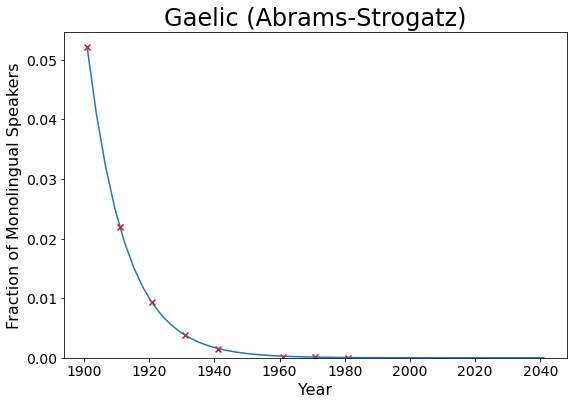

In [25]:
AS_bestGuess = [0.5, 1]

gaelic_AS_RealData, gaelic_AS_ModelData, gaelic_AS_bestParams, gaelic_AS_MSE = AS(gaelic_data,
                                                                              AS_bestGuess=AS_bestGuess)
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, gaelic_AS_RealData, gaelic_AS_ModelData,
                           t0=1901, ymin=0,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Gaelic (Abrams-Strogatz)")

Is this similar to what we expected?

In [26]:
gaelic_AS_bestParams

array([0.45465339, 0.9991082 ])

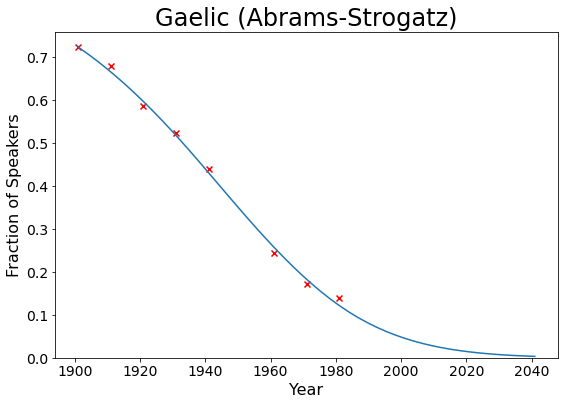

In [27]:
gaelic2_AS_RealData, gaelic2_AS_ModelData, gaelic2_AS_bestParams, gaelic2_AS_MSE = AS(gaelic_data, opt=True,
                                                                              AS_bestGuess=AS_bestGuess)
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, gaelic2_AS_RealData, gaelic2_AS_ModelData,
                           t0=1901, ymin=0,
                           axes_labels=["Year", "Fraction of Speakers"], title="Gaelic (Abrams-Strogatz)")

In [28]:
gaelic2_AS_bestParams

array([0.48282266, 1.01597858])

#### b. Zhang-Gong:

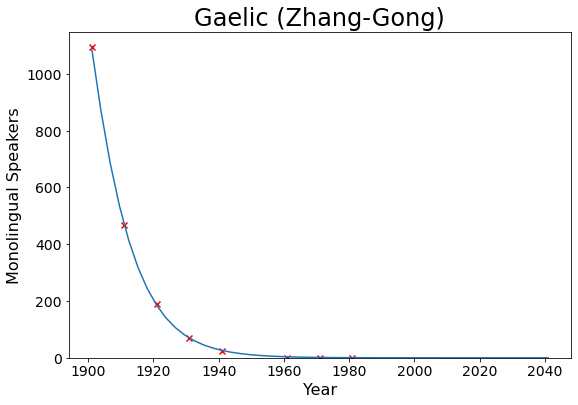

In [29]:
gaelic_ZG_RealData, gaelic_ZG_ModelData, gaelic_ZG_bestParams, gaelic_ZG_MSE = ZG(gaelic_data)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, gaelic_ZG_RealData, gaelic_ZG_ModelData,
                           ymin=0, t0=1901, title="Gaelic (Zhang-Gong)")

How do the parameters compare?

In [30]:
gaelic_ZG_bestParams

array([9.85676233e-01, 1.89815343e-02, 1.89931723e+00, 6.25016615e+00,
       7.43285884e+03, 1.15579777e+04])

#### c. Luck-Mehta

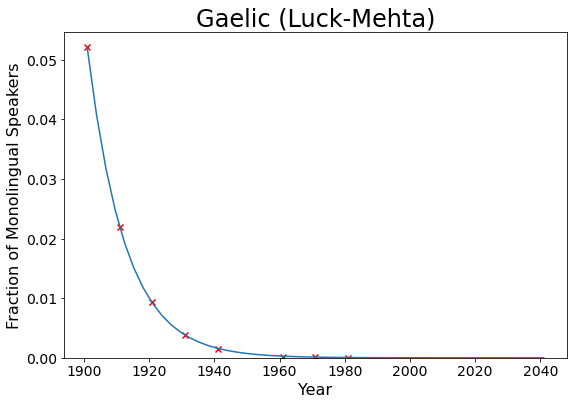

In [31]:
LM_bestGuess = [0.5, 1]

gaelic_LM_RealData, gaelic_LM_ModelData, gaelic_LM_bestParams, gaelic_LM_MSE = LM(gaelic_data,
                                                                                  LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, gaelic_LM_RealData, gaelic_LM_ModelData,
                           ymin=0, t0=1901,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Gaelic (Luck-Mehta)")

In [32]:
np.sum(gaelic_LM_bestParams)

1.0875633604581716

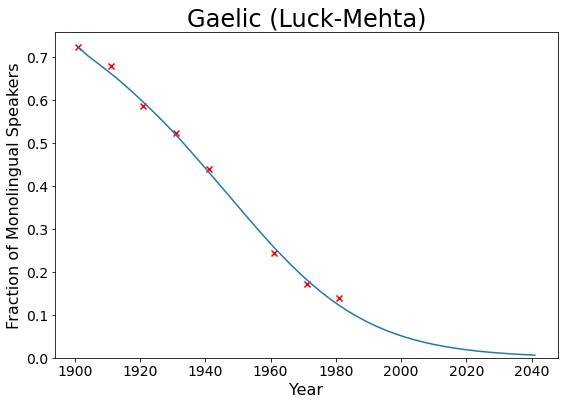

In [33]:
LM_bestGuess = [0.5, 1]

gaelic_LM_RealData, gaelic_LM_ModelData, gaelic_LM_bestParams, gaelic_LM_MSE = LM(gaelic_data,opt=True,
                                                                                  LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, gaelic_LM_RealData, gaelic_LM_ModelData,
                           ymin=0, t0=1901,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Gaelic (Luck-Mehta)")

In [34]:
np.sum(gaelic_LM_bestParams)

1.0532834194227851

### 3.2. Welsh vs. English:

#### a. Abrams-Strogatz:

Not considering bilinguals:

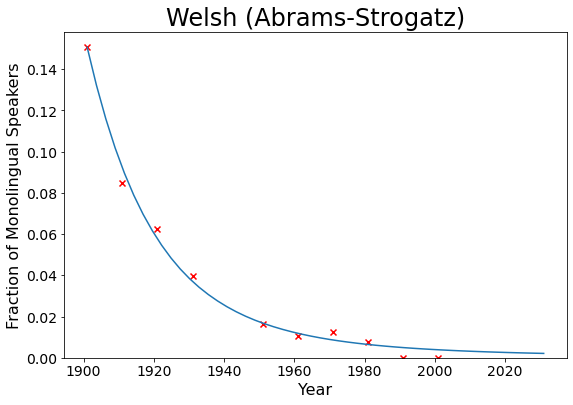

In [13]:
AS_bestGuess = [0.5, 1]

welsh_AS_RealData, welsh_AS_ModelData, welsh_AS_bestParams, welsh_AS_MSE = AS(welsh_hist_data,
                                                                              AS_bestGuess=AS_bestGuess)
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_AS_RealData, welsh_AS_ModelData,
                           t0=1901, ymin=0,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Welsh (Abrams-Strogatz)")

Is this similar to what we expected?

In [14]:
welsh_AS_bestParams

array([0.46349909, 0.98160145])

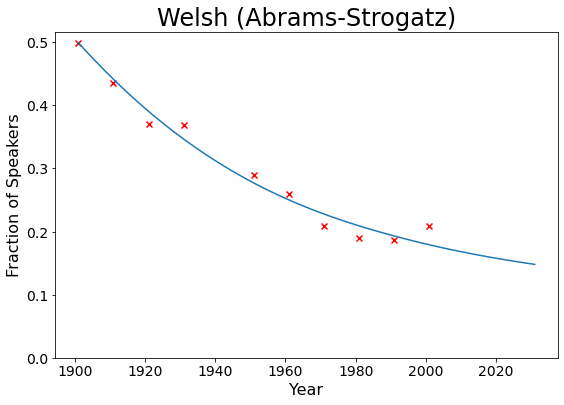

In [38]:
welsh_AS_RealData, welsh_AS_ModelData, welsh_AS_bestParams, welsh_AS_MSE = AS(welsh_hist_data,
                                                                              AS_bestGuess=AS_bestGuess,
                                                                            opt= True)
fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_AS_RealData, welsh_AS_ModelData,
                           t0=1901, ymin=0,
                           axes_labels=["Year", "Fraction of Speakers"], title="Welsh (Abrams-Strogatz)")

In [32]:
welsh_AS_bestParams

array([0.48382422, 0.95185829])

#### b. Zhang-Gong:

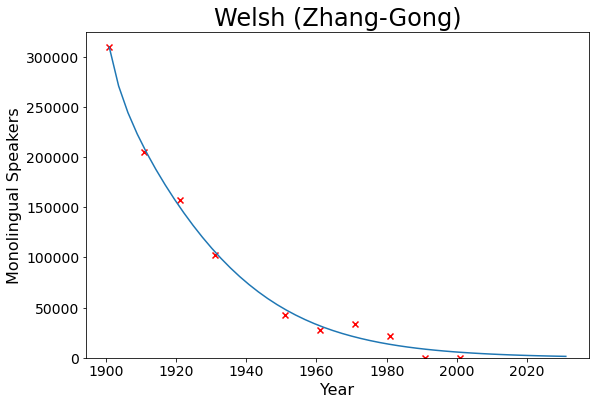

In [17]:
welsh_ZG_RealData, welsh_ZG_ModelData, welsh_ZG_bestParams, welsh_ZG_MSE = ZG(welsh_hist_data)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_ZG_RealData, welsh_ZG_ModelData,
                           ymin=0, t0=1901, title="Welsh (Zhang-Gong)")

How do the parameters compare?

In [18]:
welsh_ZG_bestParams

array([2.60881886e-01, 2.13607943e-02, 2.64977303e+00, 3.11420891e+00,
       8.63629193e+05, 2.34990890e+06])

#### c. Luck-Mehta

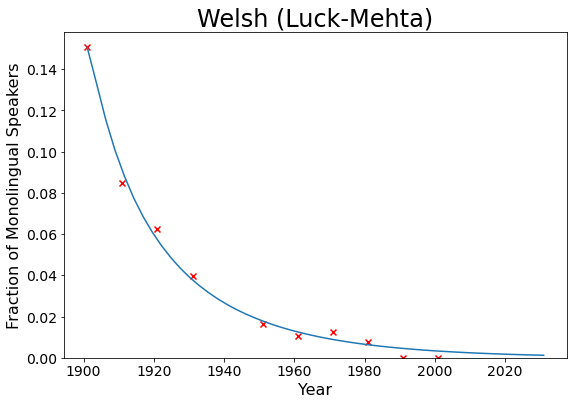

In [19]:
LM_bestGuess = [0.5, 1]

welsh_LM_RealData, welsh_LM_ModelData, welsh_LM_bestParams, welsh_LM_MSE = LM(welsh_hist_data, LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh_LM_RealData, welsh_LM_ModelData,
                           ymin=0, t0=1901,
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="Welsh (Luck-Mehta)")

In [20]:
np.sum(welsh_LM_bestParams)

1.032204774477461

What if we add bilinguals to LM?

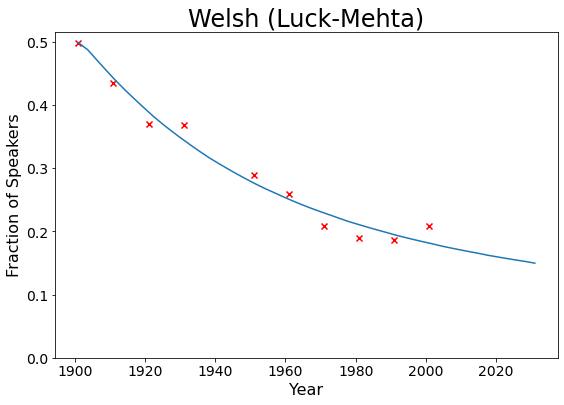

In [40]:
welsh2_LM_RealData, welsh2_LM_ModelData, welsh2_LM_bestParams, welsh2_LM_MSE = LM(welsh_hist_data, opt=True,
                                                                              LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh2_LM_RealData, welsh2_LM_ModelData,
                           ymin=0, t0=1901,
                           axes_labels=["Year", "Fraction of Speakers"], title="Welsh (Luck-Mehta)")

In [41]:
np.sum(welsh2_LM_bestParams)

0.9981530702081158

$$X = \dfrac{1 - q - C}{1 - q^2 + C^2}$$

In [42]:
q_opt, C_opt = welsh2_LM_bestParams[0], welsh2_LM_bestParams[1]
eq = (1-q_opt-C_opt)/(1-q_opt**2 + C_opt**2)
eq

0.03249459249803213

What if we add two more datapoints for recent trends?

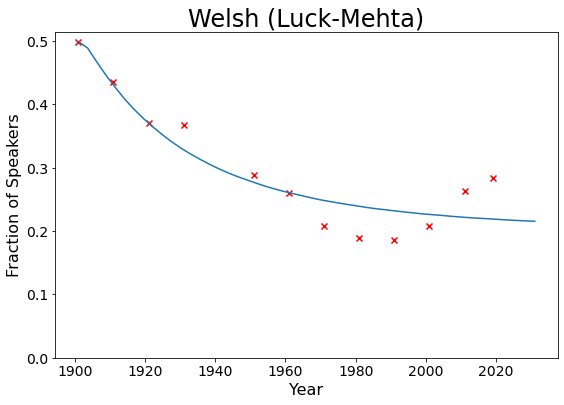

In [43]:
welsh3_LM_RealData, welsh3_LM_ModelData, welsh3_LM_bestParams, welsh3_LM_MSE = LM(welsh_select_data, opt=True,
                                                                              LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, welsh3_LM_RealData, welsh3_LM_ModelData,
                           ymin=0, t0=1901,
                           axes_labels=["Year", "Fraction of Speakers"], title="Welsh (Luck-Mehta)")

In [44]:
np.sum(welsh3_LM_bestParams)

0.9748816120444742

$$X = \dfrac{1 - q - C}{1 - q^2 + C^2}$$

In [45]:
q_opt, C_opt = welsh3_LM_bestParams[0], welsh3_LM_bestParams[1]
eq = (1-q_opt-C_opt)/(1-q_opt**2 + C_opt**2)
eq

0.20371877429826513

### 3.3. French vs. English (Montreal)

#### a. Abrams-Strogatz

Here we consider bilingualism.

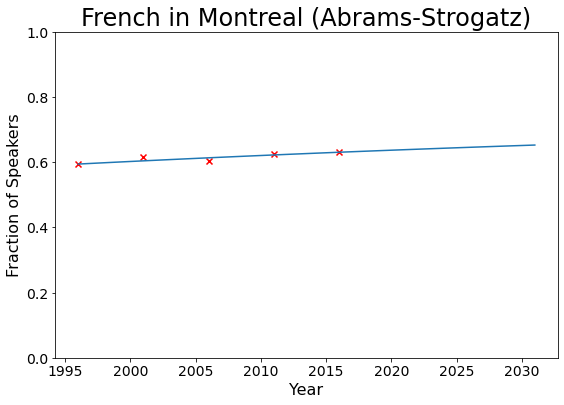

In [39]:
canada2_AS_RealData, canada2_AS_ModelData, canada2_AS_bestParams, canada2_AS_MSE = AS(canada_data,
                                                                                  AS_bestGuess=AS_bestGuess,
                                                                                 opt=True)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada2_AS_RealData, canada2_AS_ModelData,
                           ymin=0, ymax=1, t0=1996,
                           axes_labels=["Year", "Fraction of Speakers"], title="French in Montreal (Abrams-Strogatz)")

In [40]:
canada2_AS_bestParams

array([0.50604566, 0.98011621])

This is roughly constant, isn't it? Well, $s\approx 0.5$ and $a\approx 1$:

$$\dfrac{dx}{dt} = s (1-x)x^a - (1-s)x(1-x)^a \approx \dfrac{1}{2}(1-x)x - \left(1 - \dfrac{1}{2}\right)x(1-x) = \dfrac{x(1-x)}{2} - \dfrac{x(1-x)}{2} = 0$$

#### b. Zhang-Gong

/Users/gsagostini/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


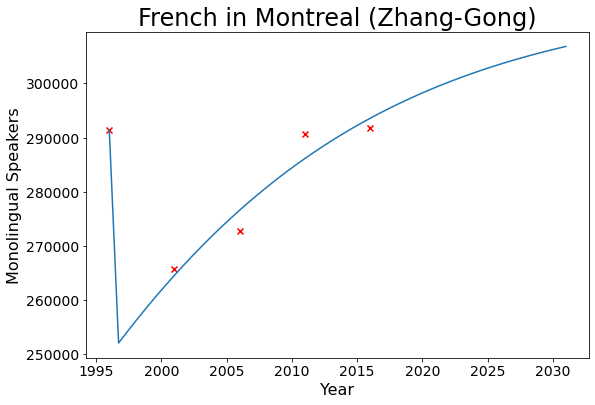

In [41]:
canada_ZG_RealData, canada_ZG_ModelData, canada_ZG_bestParams, canada_ZG_MSE = ZG(canada_data)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_ZG_RealData, canada_ZG_ModelData,
                           t0=1996, title="French in Montreal (Zhang-Gong)")

In [42]:
canada_ZG_bestParams

array([1.56389803e-01, 6.20219214e-02, 1.42626762e+02, 6.10102343e+01,
       1.76295961e+06, 3.16133466e+05])

What if we use their estimation?

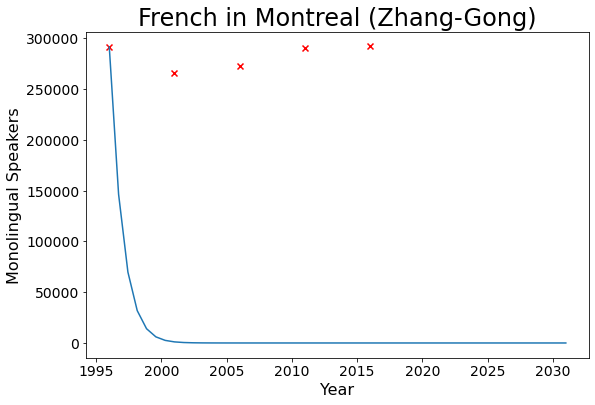

In [43]:
ZG_bestGuess = ZG_estimate(canada_data)
r_1, r_2, sigma_1, sigma_2, N_1, N_2 = ZG_bestGuess

IC = np.array([canada_data.values[0, 1], canada_data.values[0, 2]])
#print(IC)
SolverTime = np.linspace(0, 2030-canada_data.values[:,0][0]+1)

def ZG_Model2(t, X):
    #print(X)
    F1 = r_1*X[0]*(1 - X[0]/N_1 - sigma_1*X[1]/N_2)
    F2 = r_2*X[1]*(1 - X[1]/N_2 - sigma_2*X[0]/N_1)
    return [F1, F2]

y = solve_ivp(ZG_Model2, (SolverTime[0], SolverTime[-1]+1), IC, t_eval = SolverTime).y[1]

canada_ZG_ModelData2 = np.array([SolverTime, y])

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_ZG_RealData, canada_ZG_ModelData2,
                           t0=1996, title="French in Montreal (Zhang-Gong)")

Distance from cultural center? What that means? Assuming $d_1 = d_2 = 0$. Recall:

$$\sigma_1 = \dfrac{Q_2}{Q_1}\exp\left(\dfrac{d^2_1 - d^2_2}{4}\right) = \dfrac{Q_2}{Q_1}\quad\text{and}\quad
\sigma_2 = \dfrac{Q_1}{Q_2}\exp\left(\dfrac{d^2_2 - d^2_1}{4}\right) = \dfrac{Q_1}{Q_2}$$

However coexistence would be possible only at:

$$ X^*_i = N_i\dfrac{1-\sigma_i}{1 - \sigma_1\sigma_2}$$

#### c. Luck-Mehta

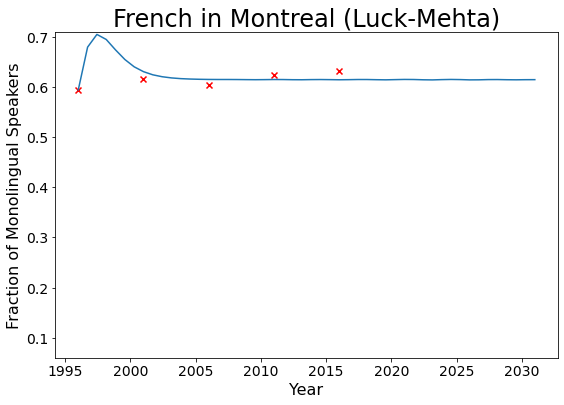

In [48]:
canada2_LM_RealData, canada2_LM_ModelData, canada2_LM_bestParams, canada2_LM_MSE = LM(canada_data, opt=True,
                                                                                  LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada2_LM_RealData, canada2_LM_ModelData,
                           ymin=0.06, t0=1996, 
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="French in Montreal (Luck-Mehta)")

In [52]:
np.sum(canada2_LM_bestParams)

0.32189293815304454

In [51]:
q_opt, C_opt = canada2_LM_bestParams[0], canada2_LM_bestParams[1]
eq = (1-q_opt-C_opt)/(1-q_opt**2 + C_opt**2)
eq

0.6144416510724419

Even if we were not to consider bilinguals, still some coexistence

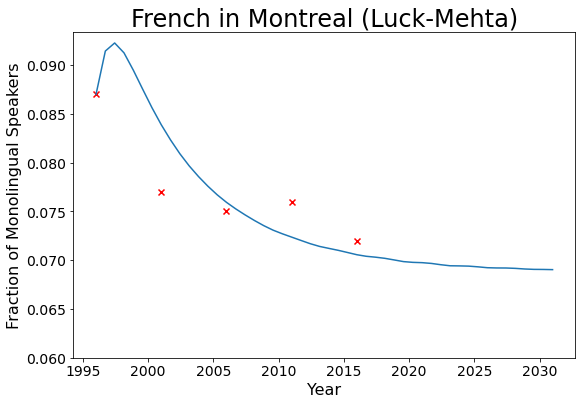

In [44]:
LM_bestGuess = [0.5, 1]

canada_LM_RealData, canada_LM_ModelData, canada_LM_bestParams, canada_LM_MSE = LM(canada_data, LM_bestGuess=LM_bestGuess)

fig = plt.figure(2,figsize=(9,6))
plot = Plot_FittedSolution(fig, canada_LM_RealData, canada_LM_ModelData,
                           ymin=0.06, t0=1996, 
                           axes_labels=["Year", "Fraction of Monolingual Speakers"], title="French in Montreal (Luck-Mehta)")

In [45]:
canada_LM_bestParams

array([1.20991207e-19, 8.78169426e-01])

In [46]:
np.sum(canada_LM_bestParams)

0.8781694259263249

$$X = \dfrac{1 - q - C}{1 - q^2 + C^2}$$

In [47]:
q_opt, C_opt = canada_LM_bestParams[0], canada_LM_bestParams[1]
eq = (1-q_opt-C_opt)/(1-q_opt**2 + C_opt**2)
eq

0.06878491632778583

## 4. Conclusions:

1. Models treat bilingualism different, but we have a choice of how to treat the data. This can influence the parameter estimation

2. The Luck-Mehta model works! With only two parameters, it provides comparable results to fits of the historical data, and it seems to be better at predicting recent data trends

3. The Zhang and Gong model works well in historical data for which language death is predicted. However, their own parameter estimation mechanism fails to allow a coexistence equilibrium point. This could be overcome (as they did in their paper) by a clever choice of the "cultural center" of a language---but once again, we are talking about unmeasuarable parameters.

4. Recent trends are not captured well by these models. Governmental incentives to bilingualism and migratory flows could be key factors in determining language death. 